# Smartphone and MCU-board data sync
This document provides an example of two independent system time sync:

1. A handheld system with rigidly attached IMU launched by an MCU board.
2. Motion Capture System (mocap) that captures movements of the handheld system by detecting light reflective markers rigidly attached to it.

The task is to find time offset between mocap and imu measurements.

Important clauses:
1. The case of these systems implies __angular velocity extraction from poses given by mocap__. It can be achieved by obtaining finite differences between orientations given by mocap. We do this procedure here.
2. Mocap system may miss poses for some timestamps, this drawback should be considered. The notebook solves this issue.
3. During data recording for this case, mocap system was triggered by MCU GPIO pin, this means there is __no clock drift__ between mocap and IMU data. Thus, only time offset to be estimated here. Clock drift handling to be done in another notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
import twistnsync as tns

def interp(t_old, f_old, t_new, kind='linear'):
    func = interp1d(t_old, f_old, kind=kind, axis=0, fill_value="extrapolate")
    f_new = func(t_new)
    return f_new

d = np.array([-1.0, 0.0, 1.0])

### Mocap data handler class

In [10]:
class Data:
    def __init__(self, path, fs=None):
        self.df = pd.read_csv(path, skiprows=6, index_col='Frame')
        if fs is not None:
            self.df['Time (Seconds)'] = np.arange(self.df['Time (Seconds)'].shape[0])/fs
        self.indexes_whole = self.df.index
        self.indexes_notna = self.df[self.df.notna().all(axis=1)].index
        
    def get_t_begins_and_ends(self):
        t_begins_and_ends = {}
        t_begins_and_ends['t_begins'] = self.get_data(self.begins_and_ends_whole['begins'], get_time=True)
        t_begins_and_ends['t_ends'] = self.get_data(self.begins_and_ends_whole['ends'], get_time=True)
        return t_begins_and_ends

    def _get_begins_and_ends_notna(self):
        begins = np.zeros((self.begins_and_ends_whole['begins'].shape[0],), dtype='int64')
        ends = np.zeros((self.begins_and_ends_whole['ends'].shape[0],), dtype='int64')
        t_begins = self.t_begins_and_ends['t_begins']['time']
        t_ends = self.t_begins_and_ends['t_ends']['time']
        time = self.get_data(self.indexes_notna, get_time=True)['time']
        for i, (t_begin, t_end) in enumerate(zip(t_begins, t_ends)):
            begins[i] = np.where(time==t_begin)[0].item()
            ends[i] = np.where(time==t_end)[0].item()

        return {'begins' : begins, 'ends' : ends}
    
    def set_begins_and_ends_whole(self, begins_and_ends_whole):
        self.begins_and_ends_whole = begins_and_ends_whole
        self.t_begins_and_ends = self._get_t_begins_and_ends()
        self.begins_and_ends_notna = self.get_begins_and_ends_notna()

    def get_data(self, notna_only=False, get_time=False, 
                 get_pos=False, get_orient=False, get_matrix=False):
        indexes = self.indexes_notna if notna_only else self.indexes_whole
        data = {}
        if get_time:
            data['time'] = self.df[['Time (Seconds)']].to_numpy().squeeze()[indexes]
        if get_pos:
            data['position'] = self.df[['X.1', 'Y.1', 'Z.1']].to_numpy()[indexes]
            
        if get_orient or get_matrix:
            orientation = self.df[['X', 'Y', 'Z', 'W']].to_numpy()[indexes]
            if get_orient:
                data['orientation'] = orientation
            if get_matrix:
                data['mcs'] = Rot(orientation).as_matrix()
        return data

### Read IMU timestamps and angular velocities

In [4]:
imu_data = pd.read_csv('data/imu.csv', header=None)

imu_time = imu_data[[0]].to_numpy().squeeze() * 1e-9
imu_omega = imu_data[[1, 2, 3]].to_numpy()

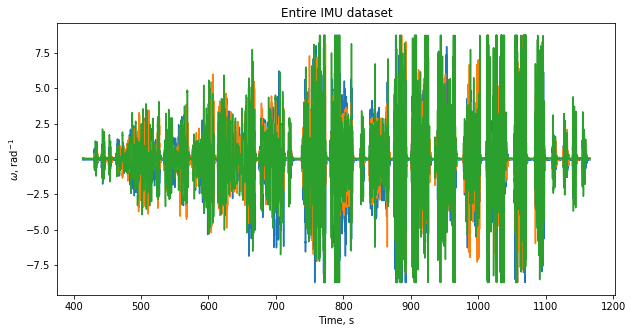

In [5]:
plt.figure(figsize=(10,5))
plt.title('Entire IMU dataset')
plt.xlabel('Time, s')
plt.ylabel(r'$\omega$, rad$^{-1}$')
plt.plot(imu_time, imu_omega);

### Take a look at non-zero IMU bias during motionless state of the platform.
The bias can be already removed if the IMU is calibrated beforehand

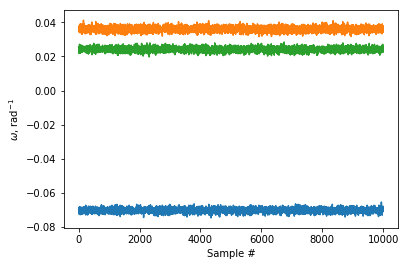

In [6]:
plt.plot(imu_omega[:10000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Substitution of the bias from the IMU measurements

In [7]:
imu_omega -= imu_omega[:10000].mean(axis=0)

### Bias is removed:

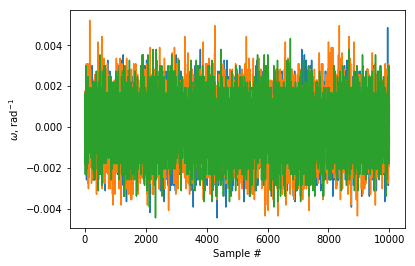

In [8]:
plt.plot(imu_omega[:10000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Read mocap data including timestamps and orientations

In [13]:
mocap_data_obj = Data('data/mocap.csv', fs=200.)

mocap_data_raw = mocap_data_obj.get_data(notna_only=False, get_time=True, get_orient=True)
mocap_time_raw = mocap_data_raw['time']
mocap_quat_raw = mocap_data_raw['orientation']

mocap_data = mocap_data_obj.get_data(notna_only=True, get_time=True, get_orient=True)
mocap_time = mocap_data['time']
mocap_quat = mocap_data['orientation']

In [17]:
begins_and_ends_whole = {}

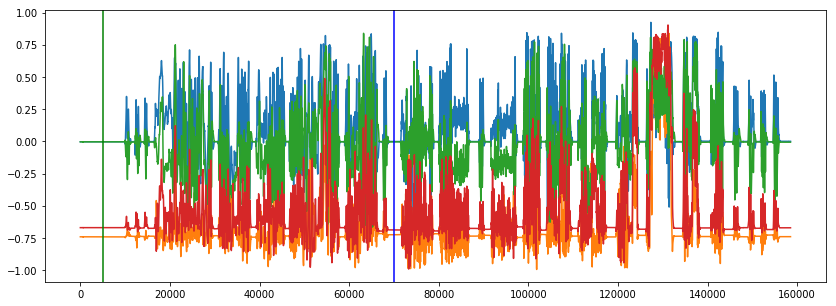

In [15]:
#begins_and_ends_whole['begins'] = np.array([4550, 6700, 8700, 10500, 14000])
#begins_and_ends_whole['ends'] = np.array([6700, 8700, 10500, 13000, 16300])
begins_and_ends_whole['begins'] = np.array([5000])
begins_and_ends_whole['ends'] = np.array([70000])

k = 0
plt.figure(figsize=(14,5))
plt.plot(data_raw['orientation'])
#plt.xlim(4400, 17500)
#    begins_and_ends_whole['begins'][k], 
#    begins_and_ends_whole['ends'][k]
#)
begins = begins_and_ends_whole['begins']
ends = begins_and_ends_whole['ends']
for begin, end in zip(begins, ends):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

In [16]:
data_obj.set_begins_and_ends_whole(begins_and_ends_whole)

In [17]:
data = data_obj.get_notna(get_time=True, get_matrix=True, get_orient=True, get_pos=True)
time = data['time']
orientation = data['mcs']
position = data['position']

In [18]:
data_raw = data_obj.get_whole(get_time=True)
#data_raw.keys()
time_raw = data_raw['time']
dt = np.diff(time_raw).mean()
dt

0.005

In [19]:
orientation_interp = interp(time, orientation, time_raw)

In [20]:
begins = data_obj.begins_and_ends_notna['begins']
ends = data_obj.begins_and_ends_notna['ends']

begins_raw = data_obj.begins_and_ends_whole['begins']
ends_raw = data_obj.begins_and_ends_whole['ends']

In [21]:
time_raw

array([0.00000e+00, 5.00000e-03, 1.00000e-02, ..., 7.92535e+02,
       7.92540e+02, 7.92545e+02])

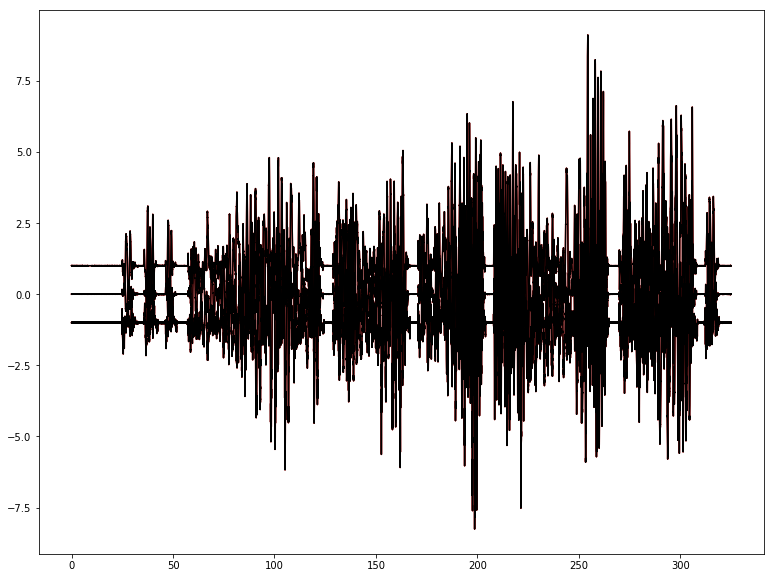

In [22]:
dR = orientation_interp[:-2].transpose(0,2,1)@orientation_interp[2:]
omega = Rot.from_matrix(dR).as_rotvec()/2/dt
omegas_filtrated = {}

plt.figure(figsize=(13,10))
for i, (begin_raw, end_raw) in enumerate(zip(begins_raw, ends_raw)):
    t = time_raw[begin_raw:end_raw]
    omega_filtrated = omega[begin_raw:end_raw]#gaussian_filter1d(omega[begin_raw:end_raw],sigma=4, axis=0)
    omegas_filtrated[i] = [t, omega_filtrated]
    plt.plot(t - time_raw[begin_raw], omega[begin_raw:end_raw]+d+i, 'r')
    plt.plot(t - time_raw[begin_raw], omega_filtrated+d+i, 'k')

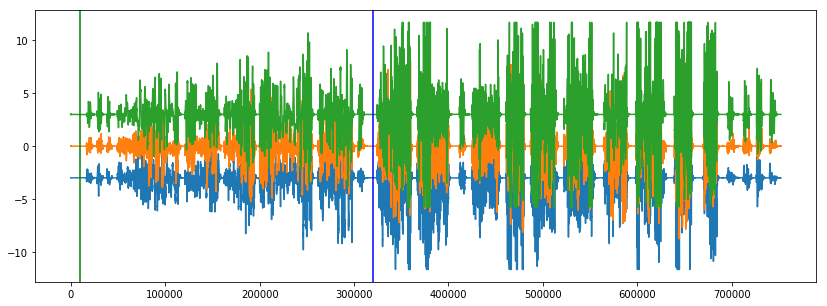

In [23]:
mcu_begins = [10000]
mcu_ends = [320000]

plt.figure(figsize=(14,5))
plt.plot(mcu_omega+d*3)
#plt.xlim(23000, None)
for begin, end in zip(mcu_begins, mcu_ends):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time_module
import datetime as datetime


-380.56471004065406


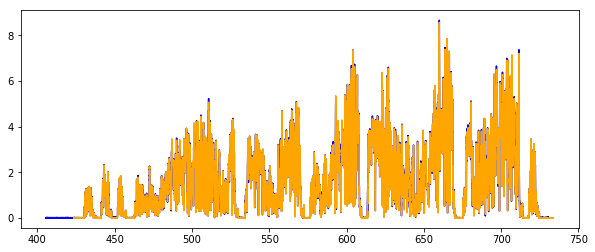

In [25]:
offsets = []
mcu_times = []
mocap_times = [omegas_filtrated[i][0] for i in range(1)]
for i, (mcu_begin, mcu_end, begin_raw, end_raw) in enumerate(zip(mcu_begins, mcu_ends, begins_raw, ends_raw)):    
    mocap_gyro_time = omegas_filtrated[i][0]
    mocap_gyro_data = omegas_filtrated[i][1]
    mcu_gyro_time = mcu_time[mcu_begin:mcu_end]
    mcu_gyro_data = mcu_omega[mcu_begin:mcu_end]

    
    #sm_gyro_data = dat[['sm_x', 'sm_y', 'sm_z']].to_numpy()
    #sm_gyro_time = dat[['sm_time']].to_numpy().squeeze()
    
    time_sync = tns.TimeSync(
        mcu_gyro_data, mocap_gyro_data, mcu_gyro_time, mocap_gyro_time, do_resample = True
    )
    time_sync.resample()
    time_sync.obtain_delay()
    # Check if IMU calibration and consequently TimeSync has succeeded
    if time_sync.calibration_is_succeeded == False or time_sync.calibration_is_succeeded is None:
        print('IMU data calibration failed. Exiting')

    comp_delay = time_sync.time_delay
    M = time_sync.M
    #print(M)
    # Compute resulting offset
    #mocap_mcu_clock_offset = np.mean(mocap_gyro_time - mcu_gyro_time) + comp_delay2
    mocap_mcu_clock_offset = (mocap_gyro_time[0] - mcu_gyro_time[0] + comp_delay)
    offsets.append(mocap_mcu_clock_offset)
    print(mocap_mcu_clock_offset)
    plt.figure(figsize=(10,4))
    plt.plot(mocap_gyro_time - mocap_mcu_clock_offset, np.linalg.norm(mocap_gyro_data, ord=2, axis=1), 'b')
    plt.plot(mcu_gyro_time, np.linalg.norm(mcu_gyro_data, ord=2, axis=1), 'orange')


# This is the final result, mocap timestamps in the IMU data time domain:

In [26]:
mocap_time_raw_aligned = mocap_time_raw - mocap_mcu_clock_offset#(slope*mocap_time_raw + intercept)
mocap_time_aligned = mocap_time - mocap_mcu_clock_offset#(slope*mocap_time + intercept)

In [27]:
mcu_time

array([ 413.65759797,  413.65859797,  413.65959797, ..., 1165.63759797,
       1165.63859793, 1165.63959797])

(-2.5, 2.5)

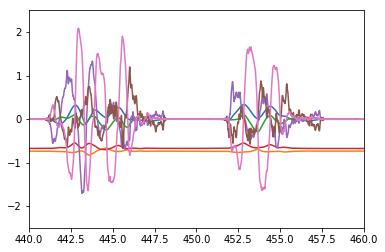

In [28]:
plt.plot(mocap_time_raw_aligned, mocap_quat_raw)
plt.plot(mcu_time, mcu_omega)
plt.xlim(440, 460)
plt.ylim(-2.5,2.5)


In [29]:
mocap_times[0] - mocap_mcu_clock_offset#(slope*np.array(mocap_times[0]) + intercept)

array([405.56471004, 405.56971004, 405.57471004, ..., 730.54971004,
       730.55471004, 730.55971004])

In [30]:
mcu_gyro_time[0], mcu_gyro_time[-1]

(423.65759796900005, 733.656597969)